In [2]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
!python run.py --test evaluate --model roberta --intervention lr --lname fc_in --lnum 11 --rate 0.9 --prop_data 0.005 --dataset counterfact --batch_size 256 --num_epochs 2 --learning_rate 0.001

In [3]:
def plot_norm(model, intervention):
    # Load the JSON file
    json_path = f"outputs/results/approximate/{intervention}/{model}/norms.json"
    with open(json_path, 'r') as json_file:
        norms_dict = json.load(json_file)

    # Extract norms and layer numbers for each layer name
    layer_data = {}
    for key, norm in norms_dict.items():
        parts = key.split('_')
        layer_num = int(parts[1])
        if len(parts) > 3:
            layer_name = parts[2] + parts[3]
        else:
            layer_name = parts[2] # e.g., "output_dense"

        if layer_name not in layer_data:
            layer_data[layer_name] = {'layer_nums': [], 'norms': []}
        
        layer_data[layer_name]['layer_nums'].append(layer_num)
        layer_data[layer_name]['norms'].append(norm)

    # Create plots for each layer name
    output_dir = f"outputs/plots/{intervention}/{model}/"
    os.makedirs(output_dir, exist_ok=True)

    # Create subplots
    num_layers = len(layer_data)
    cols = 2
    rows = (num_layers + 1) // cols  # Ensure enough rows to fit all subplots

    fig, axs = plt.subplots(rows, cols, figsize=(10, 5 * rows))

    # Convert axs to a list if it's not already one
    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    for i, (layer_name, data) in enumerate(layer_data.items()):
        axs[i].plot(data['layer_nums'], data['norms'], marker='o')
        axs[i].set_xlabel('Layer Number')
        axs[i].set_ylabel('Frobenius Norm')
        axs[i].set_title(f'F-Norm vs Layer Num for {layer_name}')
        axs[i].grid(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()


    plt.savefig(os.path.join(output_dir, 'layer_norms_subplots.png'))
    plt.show()

    print(f"Plots saved to {output_dir}")


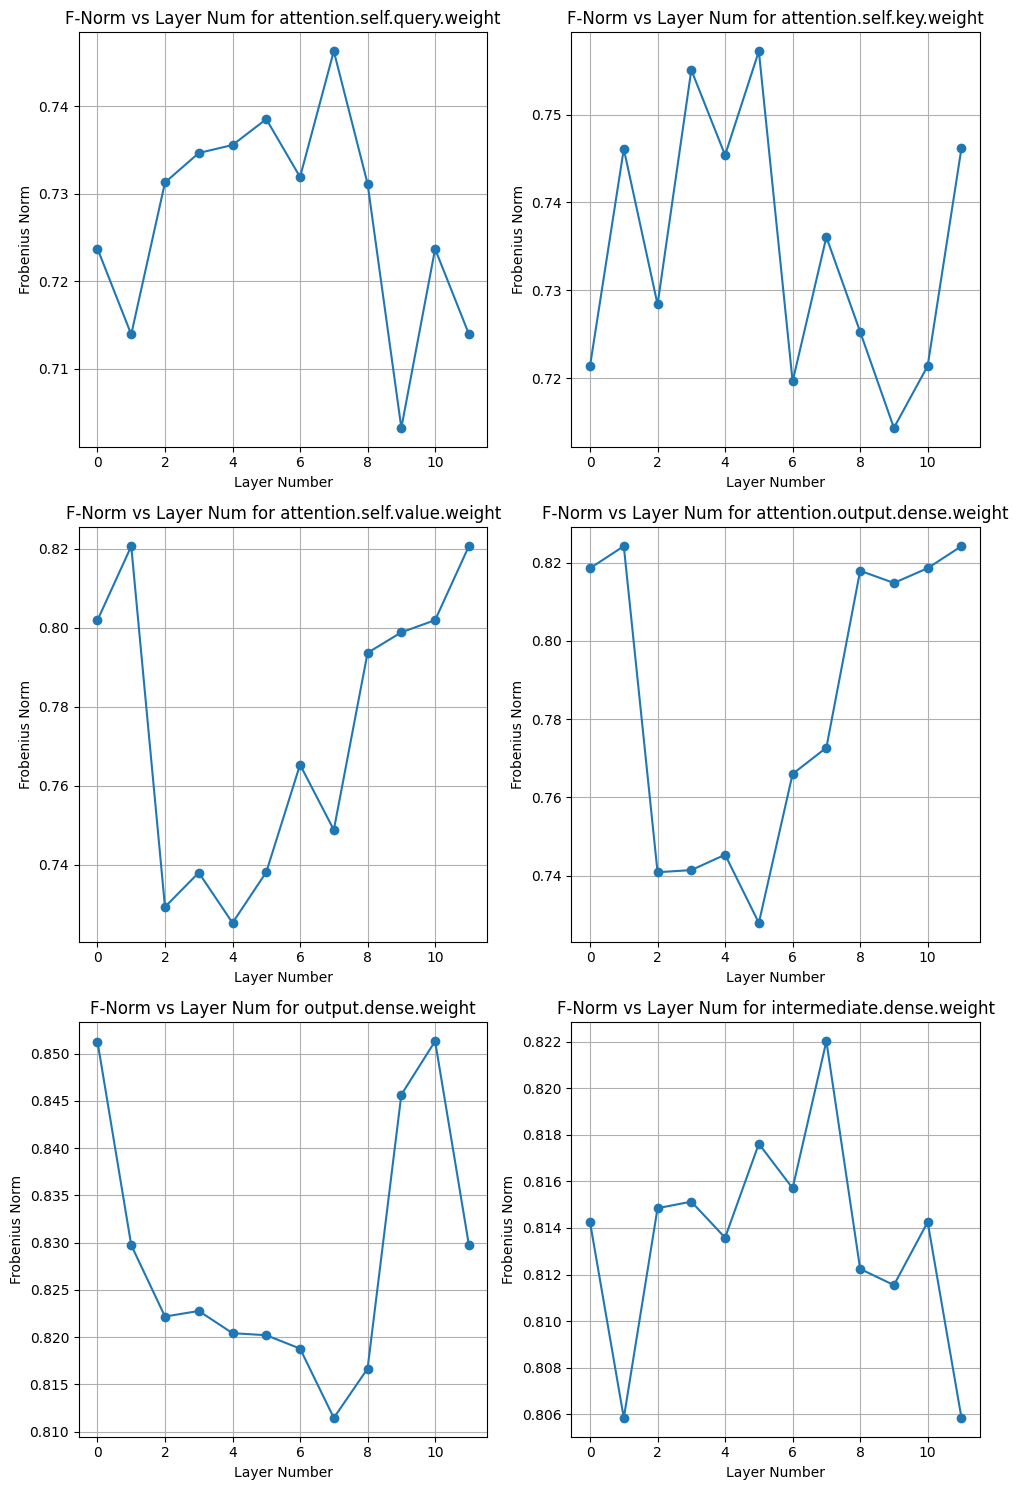

Plots saved to outputs/plots/lr/roberta/


In [4]:
plot_norm("roberta", "lr")

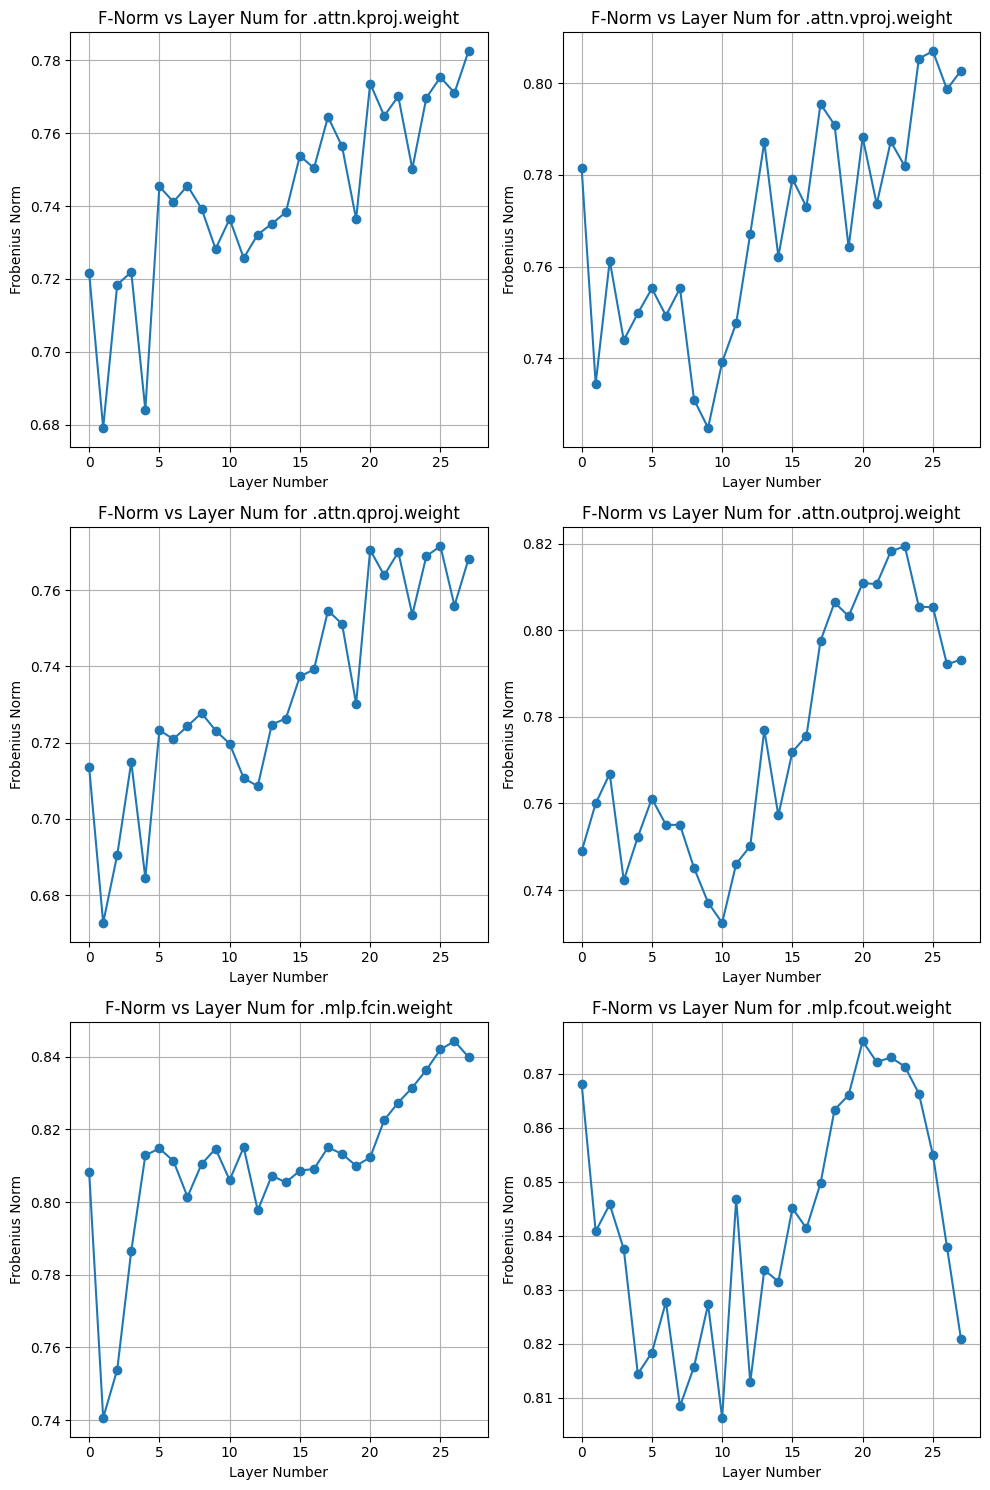

Plots saved to outputs/plots/lr/gptj/


In [5]:
plot_norm("gptj", "lr")

In [6]:
def plot_correctness_vs_lnum(model, intervention, dataset):

    csv_path = f'outputs/results/evaluate/{intervention}/{model}/{dataset}.csv'

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Ensure 'args/lnum' is treated as integers
    df['args/lnum'] = df['args/lnum'].astype(int)
    
    # Group by 'args/lname' to create separate plots for each type
    grouped = df.groupby('args/lname')
    
    # Create a figure for the plots
    num_groups = len(grouped)
    fig, axs = plt.subplots(num_groups, 1, figsize=(10, 5 * num_groups))
    
    # Flatten the axs array if there are multiple subplots
    if num_groups > 1:
        axs = axs.flatten()
    else:
        axs = [axs]
    
    # Iterate through each group and plot
    for i, (lname, group) in enumerate(grouped):
        axs[i].plot(group['args/lnum'], group['0-1 correctness'], marker='o', label=lname)
        axs[i].set_xlabel('Layer Number (args/lnum)')
        axs[i].set_ylabel('Correctness (0-1 correctness)')
        axs[i].set_title(f'Correctness vs Layer Number for {lname}')
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    output_dir = f'outputs/plots/{intervention}/{model}/{dataset}_accuracy_vs_lnum.png'
    plt.savefig(output_dir)
    plt.show()



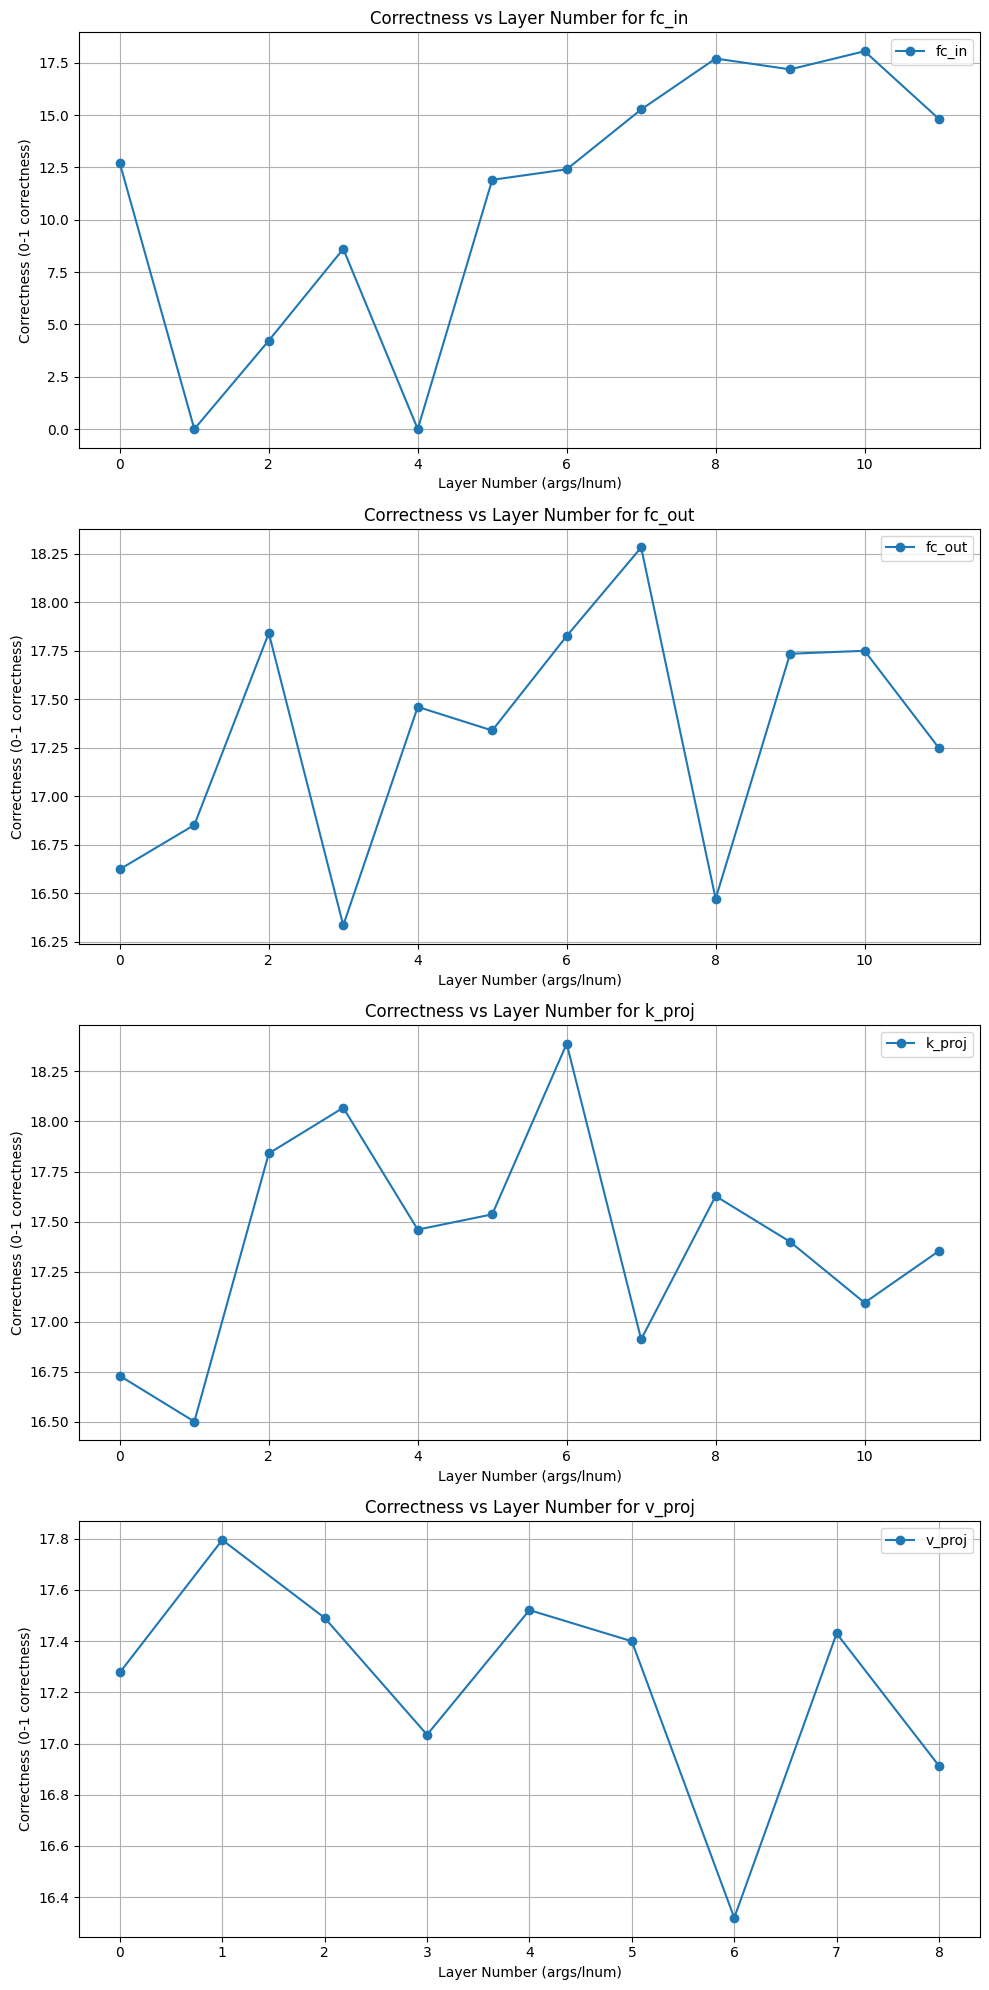

In [7]:

plot_correctness_vs_lnum("roberta", "lr", "counterfact")

In [8]:
def plot_accuracy_vs_frobenius(model, intervention, dataset):

    csv_path = f'outputs/results/evaluate/{intervention}/{model}/{dataset}.csv'

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)

    # Ensure 'args/lnum' and 'Frobenius_ratio' are treated as appropriate types
    df['args/lnum'] = df['args/lnum'].astype(int)
    df['Frobenius_ratio'] = df['Frobenius_ratio'].astype(float)

    # Group by 'args/lname' to plot each layer type in different colors
    grouped = df.groupby('args/lname')
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Define a list of colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y']

    # Iterate through each group and plot
    for i, (lname, group) in enumerate(grouped):
        color = colors[i % len(colors)]  # Cycle through colors if there are more groups than colors
        plt.scatter(group['Frobenius_ratio'], group['top-1 accuracy'], color=color, label=lname)
    
    # Set labels, title, legend, and grid
    plt.xlabel('Frobenius Norm (Frobenius_ratio)')
    plt.ylabel('Top-1 Accuracy (top-1 accuracy)')
    plt.title('Top-1 Accuracy vs Frobenius Norm for Different Layers')
    plt.legend()
    plt.grid(True)
    
    output_dir = f'outputs/plots/{intervention}/{model}/{dataset}_accuracy_vs_norm.png'
    plt.savefig(output_dir)

    plt.show()

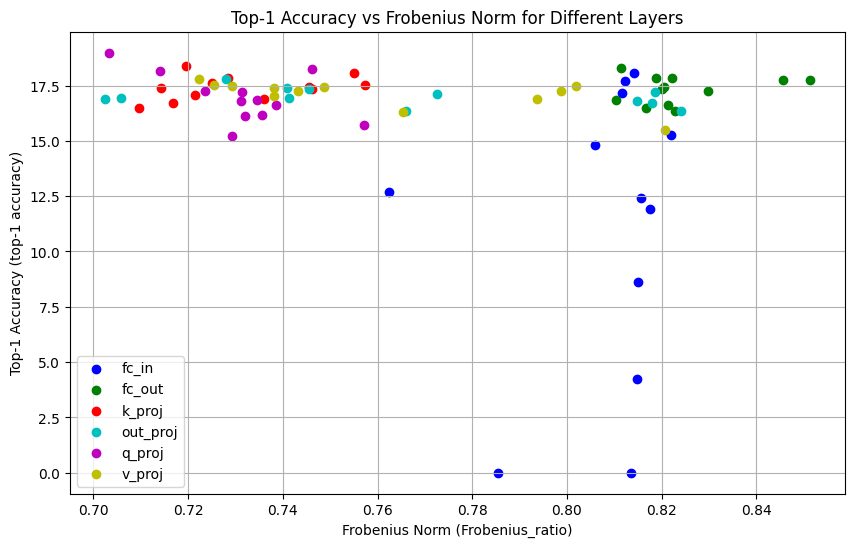

In [10]:
plot_accuracy_vs_frobenius("roberta", "lr", "counterfact")